In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

# Loading Dataset

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


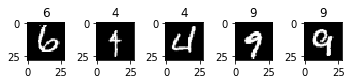

In [ ]:
from tensorflow.keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

# Data Preparation

In [ ]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255

train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))

print (train_data.shape, test_data.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


# VAE

## Encoder Part

In [ ]:
import tensorflow

input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

## Latent Distribution and Sampling

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [ ]:
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [ ]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 64)   36928       max_pooling2d[0][0]              
_______________________________________________________________________________________

## Decoder Part

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(2))
decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [ ]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 64)          36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 5, 5, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 12, 12, 64)       

## Combining

In [ ]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)

In [ ]:
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

## Loss Function (Reconstruction Loss + KL-loss)

In [ ]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

## Training

In [ ]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 2)                 57652     
_________________________________________________________________
functional_3 (Functional)    (None, 28, 28, 1)         112577    
Total params: 170,229
Trainable params: 170,229
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#tensorflow.config.run_functions_eagerly(True)#experimental_

In [ ]:
autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, validation_data=(test_data, test_data))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
59968/60000 [============================>.] - ETA: 0s - loss: 43.5907WARNING:tensorflow:From /Users/k15/anaconda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
60000/60000 [==============================] - 82s 1ms/sample - loss: 43.5876 - val_loss: 39.2346
Epoch 2/20
60000/60000 [==============================] - 83s 1ms/sample - loss: 37.9965 - val_loss: 37.2783
Epoch 3/20
60000/60000 [==============================] - 84s 1ms/sample - loss: 36.7326 - val_loss: 36.1599
Epoch 4/20
60000/60000 [==============================] - 85s 1ms/sample - loss: 36.1045 - val_loss: 35.7573
Epoch 5/20
60000/60000 [==============================] - 86s 1ms/sample - loss: 

Real Test Images


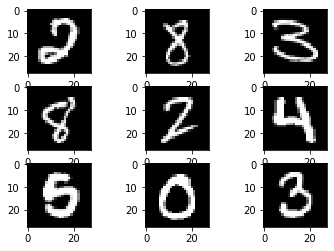

Reconstructed Images with Variational Autoencoder


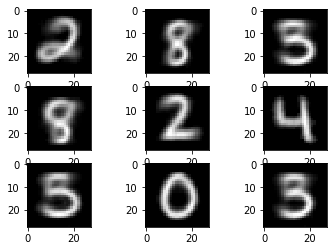

In [ ]:
offset=400
print ("Real Test Images")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_data[i+offset,:,:, -1], cmap='gray')
plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_data[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()

## Latent feature clusters

In [ ]:
x = []
y = []
z = []
for i in range(10000):
    z.append(testy[i])
    op = encoder_model.predict(np.array([test_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])

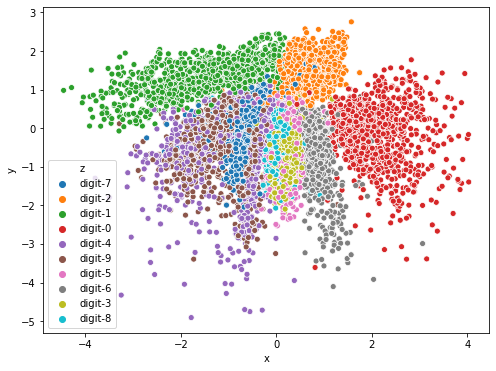

In [ ]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["digit-"+str(k) for k in z]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

## Image Generation

In [ ]:
generator_model = decoder_model

In [ ]:
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)

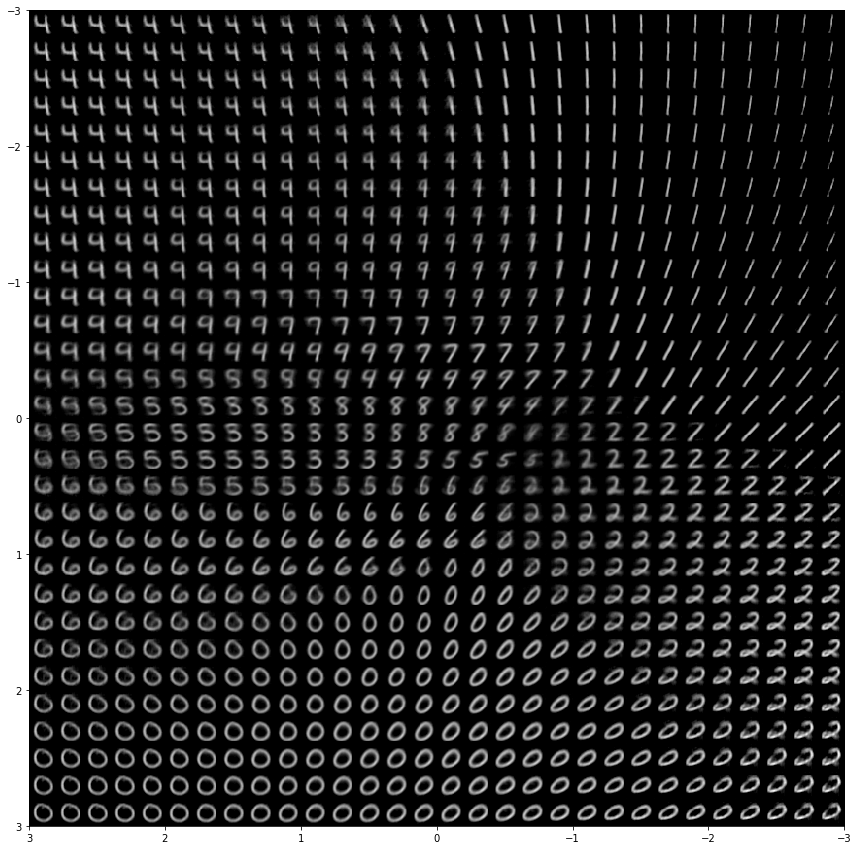

In [ ]:
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = generator_model.predict(latent_point)[0]
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]
 
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
plt.show()